In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
pwd

'/Users/sebas/projects/metabolomics/notebooks/ordinal_classification'

In [3]:
import os 
os.chdir('/Users/sebas/projects/metabolomics/')
# Set the environment variable
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [4]:
import dill
import torch
from torch.utils.data import DataLoader
import lightning.pytorch as pl

from pytorch_lightning.callbacks import ProgressBar
from src.train_utils import TrainUtils
import matplotlib.pyplot as plt
from src.config import Config
import numpy as np
from torch.utils.data import DataLoader, WeightedRandomSampler
import os
from src.parser import Parser
import random
from src.weight_sampling import WeightSampling
from src.losscallback import LossCallback
from src.molecular_pairs_set import MolecularPairsSet
from src.sanity_checks import SanityChecks
from src.transformers.postprocessing import Postprocessing
from scipy.stats import spearmanr
import seaborn as sns
from src.ordinal_classification.load_data_ordinal import LoadDataOrdinal
from src.ordinal_classification.embedder_ordinal import EmbedderOrdinal
from sklearn.metrics import confusion_matrix


In [5]:
## Replicate standard regression training DONE


In [6]:
## Discretize the range

In [7]:
## Train a classification model

In [8]:
## Use gumbel softmax function

In [9]:
config = Config()

In [10]:
config.USE_GUMBEL=True

In [11]:
config.N_CLASSES=11

In [12]:
config.D_MODEL=128

In [13]:
config.bins_uniformise_INFERENCE=config.N_CLASSES-1

In [14]:
config.use_uniform_data_INFERENCE = True

## Replicate standard regression training

In [15]:
data_folder= '/Users/sebas/projects/data/'
dataset_path= data_folder +'merged_gnps_nist_20240311_unique_smiles_1_million.pkl'

In [16]:
config.dataset_path=dataset_path
config.CHECKPOINT_DIR = data_folder + 'temp_training/'

In [17]:
# parameters
dataset_path = config.dataset_path
epochs = config.epochs
bins_uniformise_inference = config.bins_uniformise_INFERENCE
enable_progress_bar = config.enable_progress_bar
fig_path = config.CHECKPOINT_DIR + f"scatter_plot_{config.MODEL_CODE}.png"
model_code = config.MODEL_CODE

In [18]:
print("loading file")
# Load the dataset from the pickle file
with open(dataset_path, "rb") as file:
    dataset = dill.load(file)

molecule_pairs_train = dataset["molecule_pairs_train"]
molecule_pairs_val = dataset["molecule_pairs_val"]
molecule_pairs_test = dataset["molecule_pairs_test"]
uniformed_molecule_pairs_test = dataset["uniformed_molecule_pairs_test"]

loading file


In [19]:

print(f"Number of pairs for train: {len(molecule_pairs_train)}")
print(f"Number of pairs for val: {len(molecule_pairs_val)}")
print(f"Number of pairs for test: {len(molecule_pairs_test)}")
print(f"Number of pairs for uniform test: {len(uniformed_molecule_pairs_test)}")

Number of pairs for train: 955957
Number of pairs for val: 586692
Number of pairs for test: 586781
Number of pairs for uniform test: 40940


In [20]:
## CALCULATION OF WEIGHTS
train_binned_list, _ = TrainUtils.divide_data_into_bins(
    molecule_pairs_train,
    config.N_CLASSES-1,
        bin_sim_1=False, 
)
#train_binned_list, _ = TrainUtils.divide_data_into_bins(
#    molecule_pairs_train,
#    config.N_CLASSES-1,
#    bin_sim_1=False, 
#)


In [21]:
[t.indexes_tani.shape for t in train_binned_list]

[(93527, 3),
 (206458, 3),
 (115367, 3),
 (50862, 3),
 (21977, 3),
 (294869, 3),
 (86199, 3),
 (29506, 3),
 (15328, 3),
 (41864, 3)]

In [22]:
weights, range_weights = WeightSampling.compute_weights(train_binned_list)
#weights, range_weights = WeightSampling.compute_weights(train_binned_list)

In [23]:
weights

array([0.04702354, 0.02130201, 0.03812156, 0.08646869, 0.20011695,
       0.014915  , 0.05102113, 0.14905342, 0.28692395, 0.10505375])

In [24]:
range_weights

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [25]:
#weights_tr = WeightSampling.compute_sample_weights_categories(molecule_pairs_train, weights)
#weights_val = WeightSampling.compute_sample_weights_categories(molecule_pairs_val, weights)
weights_tr = WeightSampling.compute_sample_weights(molecule_pairs_train, weights)
weights_val = WeightSampling.compute_sample_weights(molecule_pairs_val, weights)

In [26]:
dataset_train = LoadDataOrdinal.from_molecule_pairs_to_dataset(molecule_pairs_train, training=True)
# dataset_test = LoadData.from_molecule_pairs_to_dataset(m_test)
dataset_val = LoadDataOrdinal.from_molecule_pairs_to_dataset(molecule_pairs_val)

Preprocessing all the data ...


261349it [00:06, 38301.03it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries
Preprocessing all the data ...


31318it [00:00, 47181.58it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


In [27]:
# delete variables that are not useful for memory savings
#del molecule_pairs_val
#del molecule_pairs_test
#del uniformed_molecule_pairs_test

In [28]:
class CustomWeightedRandomSampler(WeightedRandomSampler):
    """WeightedRandomSampler except allows for more than 2^24 samples to be sampled"""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __iter__(self):
        rand_tensor = np.random.choice(
            range(0, len(self.weights)),
            size=self.num_samples,
            p=self.weights.numpy() / torch.sum(self.weights).numpy(),
            replace=self.replacement,
        )
        rand_tensor = torch.from_numpy(rand_tensor)
        return iter(rand_tensor.tolist())


train_sampler = CustomWeightedRandomSampler(
    weights=weights_tr, num_samples=len(dataset_train), replacement=True
)
val_sampler = CustomWeightedRandomSampler(
    weights=weights_val, num_samples=len(dataset_val), replacement=True
)

In [29]:
weights_tr

array([1.06920996e-06, 1.06920996e-06, 1.06920996e-06, ...,
       2.38868718e-06, 2.38868718e-06, 2.38868718e-06])

In [30]:
dataset['molecule_pairs_train'].indexes_tani

array([[0.00000000e+00, 3.14000000e+02, 3.28305252e-02],
       [0.00000000e+00, 5.74000000e+02, 5.78439981e-02],
       [0.00000000e+00, 1.01500000e+03, 9.54428166e-02],
       ...,
       [2.95370000e+04, 2.95370000e+04, 1.00000000e+00],
       [2.95380000e+04, 2.95380000e+04, 1.00000000e+00],
       [2.95390000e+04, 2.95390000e+04, 1.00000000e+00]])

In [31]:
print("Creating train data loader")
dataloader_train = DataLoader(
    dataset_train, batch_size=config.BATCH_SIZE, sampler=train_sampler, num_workers=10
)

Creating train data loader


In [32]:
def worker_init_fn(
    worker_id,
):  # ensure the dataloader for validation is the same for every epoch
    seed = 42
    torch.manual_seed(seed)
    # Set the same seed for reproducibility in NumPy and Python's random module
    np.random.seed(seed)
    random.seed(seed)


print("Creating val data loader")
dataloader_val = DataLoader(
    dataset_val,
    batch_size=config.BATCH_SIZE,
    sampler=val_sampler,
    worker_init_fn=worker_init_fn,
    num_workers=0,
)


Creating val data loader


In [33]:
# Define the ModelCheckpoint callback
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=config.CHECKPOINT_DIR,
    filename="best_model",
    monitor="validation_loss_epoch",
    mode="min",
    save_top_k=1,
)

checkpoint_n_steps_callback = pl.callbacks.ModelCheckpoint(
    dirpath=config.CHECKPOINT_DIR,
    filename="best_model_n_steps",
    every_n_train_steps=1000,
    save_last=True,
    save_top_k=1,
)


# checkpoint_callback = SaveBestModelCallback(file_path=config.best_model_path)
progress_bar_callback = ProgressBar()

# loss callback
losscallback = LossCallback(file_path=config.CHECKPOINT_DIR + f"loss.png")
print("define model")


define model


In [34]:
config.USE_GUMBEL

True

In [35]:
model = EmbedderOrdinal(
    d_model=int(config.D_MODEL),
    n_layers=int(config.N_LAYERS),
    n_classes=config.N_CLASSES,
    weights=None,
    lr=config.LR,
    use_cosine_distance=config.use_cosine_distance,
    use_gumbel = config.USE_GUMBEL,
)

Using cosine library from Pytorch?: True


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/sebas/projects/data/temp_training exists and is not empty.

   | Name                    | Type                             | Params
------------------------------------------------------------------------------
0  | linear                  | Linear                           | 16.5 K
1  | linear_regression       | Linear                           | 129   
2  | fixed_linear_regression | FixedLinearRegression            | 129   
3  | relu                    | ReLU                             | 0     
4  | spectrum_encoder        | SpectrumTransformerEncoderCustom | 1.7 M 
5  | regression_loss         | MSELoss                          | 0     
6  | dropout                 | Dropout         

Sanity Checking: |                                                                                            …

/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/Users/sebas/projects/metabolomics/src/transformers/spectrum_transformer_encoder_custom.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mass_precursor = torch.tensor(kwargs["precursor_mass"].float())
/Users/sebas/projects/metabolomics/src/transformers/spectrum_transformer_encoder_custom.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  charge_precursor = 

Train loss:
[]
Validation loss
[2.351292371749878]


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                                                                                   …

/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:369: `ModelCheckpoint(monitor='validation_loss_epoch')` could not find the monitored key in the returned metrics: ['train_loss', 'train_loss_step', 'train_loss_epoch', 'epoch', 'step']. HINT: Did you call `log('validation_loss_epoch', value)` in the `LightningModule`?
`Trainer.fit` stopped: `max_steps=1000` reached.


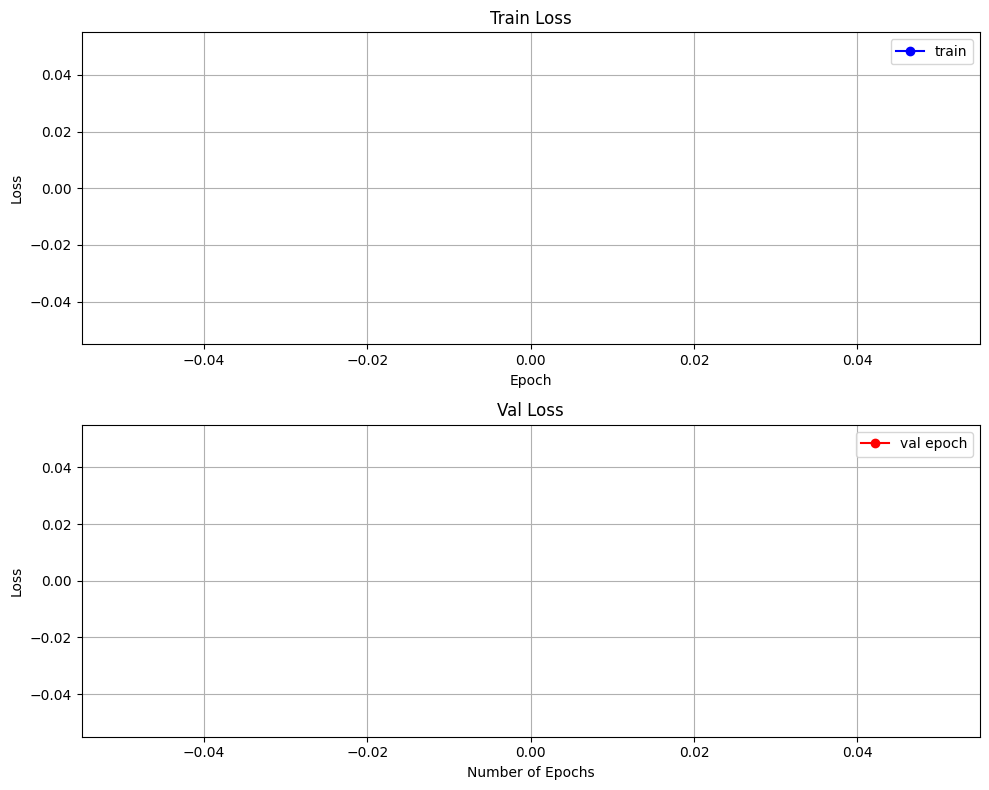

In [36]:
trainer = pl.Trainer(
    max_steps=1000,
    #max_epochs=1,
    callbacks=[checkpoint_callback, checkpoint_n_steps_callback, losscallback],
    enable_progress_bar=enable_progress_bar,
    # val_check_interval= config.validate_after_ratio,
)
# trainer = pl.Trainer(max_steps=100,  callbacks=[checkpoint_callback, losscallback], enable_progress_bar=enable_progress_bar)
trainer.fit(
    model=model,
    train_dataloaders=(dataloader_train),
    val_dataloaders=dataloader_val,
)

## Inference

In [62]:
#best_model_path = model_path = data_folder + 'best_model_exhaustive_sampled_128n_20240618.ckpt'
#best_model_path = config.CHECKPOINT_DIR + f"best_model_n_steps-v9.ckpt"
best_model_path = config.CHECKPOINT_DIR + f"last-v4.ckpt"

In [63]:
molecule_pairs_test = dataset["molecule_pairs_test"]
print(f"Number of molecule pairs: {len(molecule_pairs_test)}")
print("Uniformize the data")
uniformed_molecule_pairs_test, _ = TrainUtils.uniformise(
    molecule_pairs_test,
    number_bins=bins_uniformise_inference,
    return_binned_list=True,
    bin_sim_1=True,
    #bin_sim_1=False,
)  # do not treat sim==1 as another bin

Number of molecule pairs: 586781
Uniformize the data


In [64]:
# dataset_train = LoadData.from_molecule_pairs_to_dataset(m_train)
dataset_test = LoadDataOrdinal.from_molecule_pairs_to_dataset(uniformed_molecule_pairs_test)
dataloader_test = DataLoader(dataset_test, batch_size=config.BATCH_SIZE, shuffle=False)

Preprocessing all the data ...


33719it [00:00, 48971.11it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


In [65]:
# Testinbest_model = Embedder.load_from_checkpoint(checkpoint_callback.best_model_path, d_model=64, n_layers=2)
trainer = pl.Trainer(max_epochs=2, enable_progress_bar=enable_progress_bar)
best_model = EmbedderOrdinal.load_from_checkpoint(
    best_model_path,
    d_model=int(config.D_MODEL),
    n_layers=int(config.N_LAYERS),
    n_classes=config.N_CLASSES,
    use_gumbel=config.USE_GUMBEL,
    use_element_wise=True,
    use_cosine_distance=config.use_cosine_distance,
    
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Using cosine library from Pytorch?: True


## Postprocessing

In [66]:
pred_test = trainer.predict(
    best_model,
    dataloader_test,
)
similarities_test = Postprocessing.get_similarities(dataloader_test)


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

/Users/sebas/projects/metabolomics/src/transformers/spectrum_transformer_encoder_custom.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mass_precursor = torch.tensor(kwargs["precursor_mass"].float())
/Users/sebas/projects/metabolomics/src/transformers/spectrum_transformer_encoder_custom.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  charge_precursor = torch.tensor(kwargs["precursor_charge"].float())


(array([3764.,    0., 3764.,    0., 3764.,    0., 3764.,    0., 3764.,
        1882.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

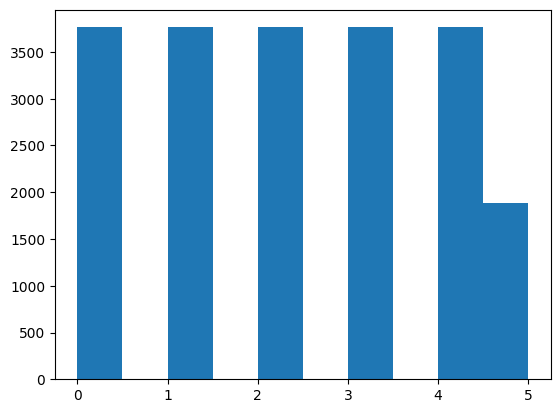

In [67]:
plt.hist(similarities_test)

In [68]:
print(pred_test[0][4])
print(similarities_test[127])

tensor([ 4.2568,  1.6854,  0.2647,  0.4382,  0.0842,  3.2764, -4.6358, -4.7865,
        -4.7823, -4.8038, -5.2848])
0.0


In [69]:
pred_test[0][6]

tensor([ 4.2169,  1.8812,  0.2064,  0.3778, -0.1978,  2.4625, -4.0834, -4.2158,
        -4.3568, -4.3451, -4.7580])

In [70]:
np.argwhere(pred_test[0][0]>0.1)[0]

tensor([0, 1, 2, 3, 4, 5])

In [71]:
np.argwhere(pred_test[0][0]>0.9)[0].numel()

3

In [72]:
def which_index(p, threshold=0.5):
    #result= np.argwhere(p>threshold)[0]
     #
    #if result.numel()==0:
        #return np.argmax(p)
    #    return np.nan
    #else:
    #    return result[-1]
    return np.argmax(p)

In [73]:
# flat the results
flat_pred_test = []
for pred in pred_test:
    flat_pred_test = flat_pred_test + [which_index(p) for p in pred]
flat_pred_test=np.array( flat_pred_test)

In [74]:
#list(pred_test)

In [75]:
flat_pred_test[0]

0

## Corr. Analysis

(array([3764.,    0., 3764.,    0., 3764.,    0., 3764.,    0., 3764.,
        1882.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

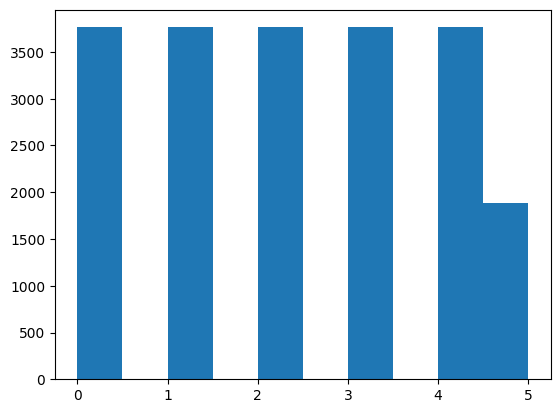

In [76]:
plt.hist(similarities_test)

In [77]:
similarities_test

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [78]:
flat_pred_test

array([0, 0, 1, ..., 0, 0, 4])

In [79]:
similarities_test=np.array(similarities_test)
flat_pred_test=np.array(flat_pred_test)

In [80]:
len(similarities_test)

20702

In [81]:
similarities_test_cleaned= similarities_test[~np.isnan(flat_pred_test)]
flat_pred_test_cleaned= flat_pred_test[~np.isnan(flat_pred_test)]

In [82]:
len(similarities_test_cleaned)

20702

In [83]:

corr_model, p_value_model= spearmanr(similarities_test_cleaned, flat_pred_test_cleaned)


In [84]:
corr_model

0.39613783226425403

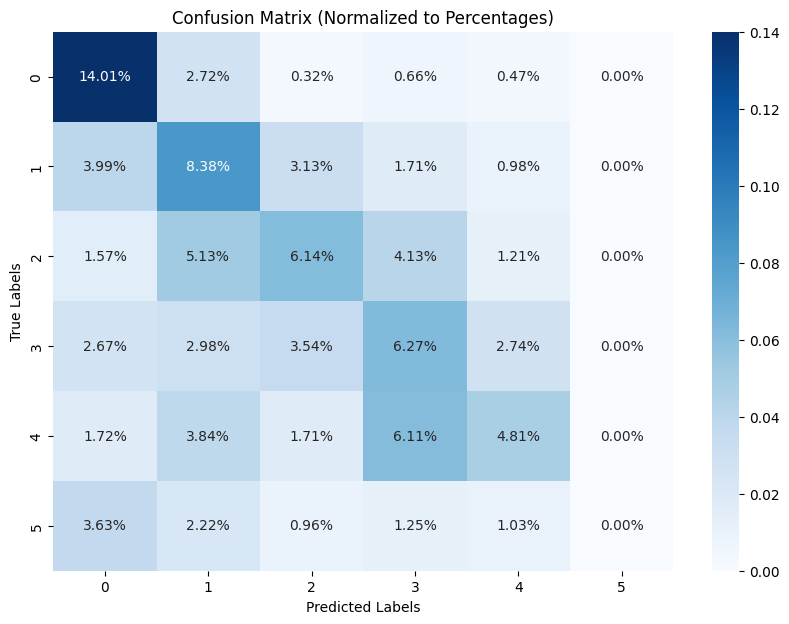

In [85]:
# Compute the confusion matrix
cm = confusion_matrix(similarities_test_cleaned, flat_pred_test_cleaned)
# Normalize the confusion matrix by the number of true instances for each class
cm_normalized = cm.astype('float') / cm.sum()
# Plot the confusion matrix with percentages
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Normalized to Percentages)')
plt.show()

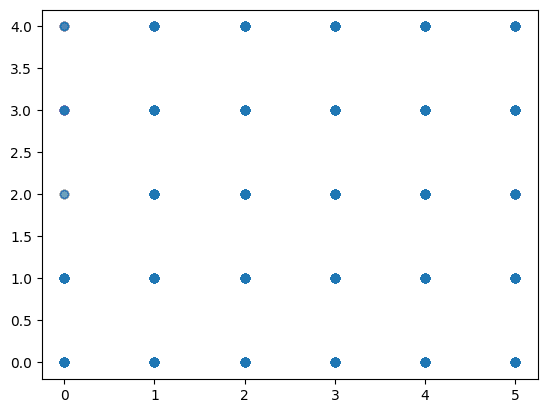

In [86]:
plt.scatter(similarities_test, flat_pred_test, alpha=0.01)

##### 